In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend, regularizers, initializers, models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [2]:
cifar100 = keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train:", len(x_train), "x_test:", len(x_test))

169017344/169001437 [==============================] - 2s 0us/step
x_train: 50000 x_test: 10000


In [3]:
def conv_blocks(input_tensor,
                kernel_size,
                filters,
                stage,
                block,
                strides=(2,2),
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
  
  filters1,filters2,filters3=filters

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  conv_base_name = 'conv' + str(stage) + block + '_branch'
  bn_base_name = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filters1,(1,1), use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_base_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2, kernel_size, strides= strides,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_base_name + '2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1), use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=conv_base_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '2c')(x)


  shortcut = layers.Conv2D(filters3,(1,1),strides=strides, use_bias=False,
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(1e-4),
                           name=conv_base_name+'1')(input_tensor)

  shortcut = layers.BatchNormalization(axis=bn_axis,
                                momentum = batch_norm_decay,
                                epsilon = batch_norm_epsilon,
                                name = bn_base_name + '1')(shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)

  return x

In [4]:
def identity_block(input_tensor,
                    kernel_size,
                    filters,
                    stage,
                    block,
                    batch_norm_decay=0.9,
                    batch_norm_epsilon=1e-5):
  
  filters1,filters2,filters3 = filters

  if backend.image_data_format()=='channels_last':
    bn_axis=3
  else:
    bn_axis=1

  id_base_name = 'identity' + str(stage) + block + '_branch'
  bn_base_name = 'identity_bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(filters1,(1,1),use_bias=False,kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=id_base_name+'2a')(input_tensor)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=batch_norm_decay,
                                epsilon=batch_norm_epsilon,
                                name=bn_base_name+'2a')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,kernel_size,padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name = id_base_name+'2b')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                         momentum = batch_norm_decay,
                         epsilon =batch_norm_epsilon,
                         name= bn_base_name+'2b')(x)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters3,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name = id_base_name+'2c')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=batch_norm_decay,
                                epsilon=batch_norm_epsilon,
                                name=bn_base_name+'2c')(x)

  x = layers.add([x,input_tensor])
  x = layers.Activation('relu')(x)

  return x

In [5]:
def resnet50(num_classes,
             batch_size=None,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):

  input_shape = (32, 32, 3)  # CIFAR100을 위한 input_shape 조정입니다. 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(img_input)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      batch_norm_decay=batch_norm_decay,
      batch_norm_epsilon=batch_norm_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=keras.regularizers.l2(1e-4),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = conv_blocks(
      x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', **block_config)

  x = conv_blocks(x, 3, [128, 128, 512], stage=3, block='a', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', **block_config)

  x = conv_blocks(x, 3, [256, 256, 1024], stage=4, block='a', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', **block_config)

  x = conv_blocks(x, 3, [512, 512, 2048], stage=5, block='a', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=keras.regularizers.l2(1e-4),
      bias_regularizer=keras.regularizers.l2(1e-4),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('softmax', dtype='float32')(x)

  # Create model.
  return models.Model(img_input, x, name='resnet50')

In [6]:
resnet50 = resnet50(num_classes=100)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9408        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

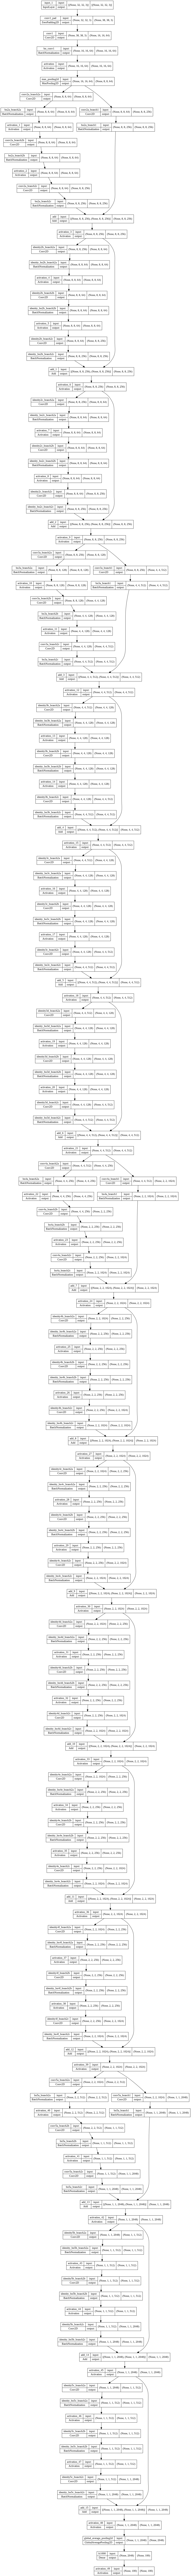

In [7]:
plot_model(resnet50,show_shapes=True)

In [8]:
resnet50.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_resnet50 = resnet50.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 79s 40ms/step - loss: 9.5998 - accuracy: 0.0672
Epoch 2/100
1563/1563 [==============================] - 63s 41ms/step - loss: 8.9957 - accuracy: 0.1368
Epoch 3/100
1563/1563 [==============================] - 63s 41ms/step - loss: 8.6524 - accuracy: 0.1863
Epoch 4/100
1563/1563 [==============================] - 63s 41ms/step - loss: 8.3716 - accuracy: 0.2284
Epoch 5/100
1563/1563 [==============================] - 64s 41ms/step - loss: 8.1353 - accuracy: 0.2688
Epoch 6/100
1563/1563 [==============================] - 64s 41ms/step - loss: 7.9102 - accuracy: 0.3058
Epoch 7/100
1563/1563 [==============================] - 64s 41ms/step - loss: 7.7077 - accuracy: 0.3400
Epoch 8/100
1563/1563 [==============================] - 64s 41ms/step - loss: 7.5126 - accuracy: 0.3777
Epoch 9/100
1563/1563 [==============================] - 64s 41ms/step - loss: 7.3132 - accuracy: 0.4112
Epoch 10/100
1563/1563 [==============================]

In [9]:
#BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)
def dense_block(input_tensor,
                filters,
                stage,
                block,
                bn_decay=0.9,
                bn_epsilon=1e-5):
  filters1,filters2=filters

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  dense_name='dense'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(input_tensor)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=dense_name+'2a')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=dense_name+'2b')(x)

  x = layers.concatenate([x,input_tensor])

  return x

In [10]:
#BN → 1×1 convolutional layer → 2×2 average pooling layer
def transition_block(input_tensor,
                     filters,
                     stage,
                     block,
                     bn_decay=0.9,
                     bn_epsilon=1e-5):
  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  transition_name = 'transition'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(input_tensor)

  x = layers.Conv2D(filters,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=transition_name+'2a')(x)

  x = layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)

  return x

In [11]:
def DenseNet121(num_classes,
                batch_size=None,
                bn_decay=0.9,
                bn_epsilon=1e-5):
  
  input_shape=(32,32,3)
  input = layers.Input(shape=input_shape,batch_size=batch_size)

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
    x = input
  else:
    x = layers.permute((3,1,2))(input)
    bn_axis=1

  config_block=dict(bn_decay=bn_decay,
                    bn_epsilon=bn_epsilon)
  x = layers.Conv2D(64,(7,7),strides=(2,2),padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name='conv1')(x)

  x = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

  x = dense_block(x,[128,32],stage=2,block='a',**config_block)
  x = dense_block(x,[128,32],stage=2,block='b',**config_block)
  x = dense_block(x,[128,32],stage=2,block='c',**config_block)
  x = dense_block(x,[128,32],stage=2,block='d',**config_block)
  x = dense_block(x,[128,32],stage=2,block='e',**config_block)
  x = dense_block(x,[128,32],stage=2,block='f',**config_block)
  x = transition_block(x,32,stage=2,block='g',**config_block)

  x = dense_block(x,[128,32],stage=3,block='a',**config_block)
  x = dense_block(x,[128,32],stage=3,block='b',**config_block)
  x = dense_block(x,[128,32],stage=3,block='c',**config_block)
  x = dense_block(x,[128,32],stage=3,block='d',**config_block)
  x = dense_block(x,[128,32],stage=3,block='e',**config_block)
  x = dense_block(x,[128,32],stage=3,block='f',**config_block)
  x = dense_block(x,[128,32],stage=3,block='g',**config_block)
  x = dense_block(x,[128,32],stage=3,block='h',**config_block)
  x = dense_block(x,[128,32],stage=3,block='i',**config_block)
  x = dense_block(x,[128,32],stage=3,block='j',**config_block)
  x = dense_block(x,[128,32],stage=3,block='k',**config_block)
  x = dense_block(x,[128,32],stage=3,block='l',**config_block)
  x = transition_block(x,32,stage=3,block='m',**config_block)

  x = dense_block(x,[128,32],stage=4,block='a',**config_block)
  x = dense_block(x,[128,32],stage=4,block='b',**config_block)
  x = dense_block(x,[128,32],stage=4,block='c',**config_block)
  x = dense_block(x,[128,32],stage=4,block='d',**config_block)
  x = dense_block(x,[128,32],stage=4,block='e',**config_block)
  x = dense_block(x,[128,32],stage=4,block='f',**config_block)
  x = dense_block(x,[128,32],stage=4,block='g',**config_block)
  x = dense_block(x,[128,32],stage=4,block='h',**config_block)
  x = dense_block(x,[128,32],stage=4,block='i',**config_block)
  x = dense_block(x,[128,32],stage=4,block='j',**config_block)
  x = dense_block(x,[128,32],stage=4,block='k',**config_block)
  x = dense_block(x,[128,32],stage=4,block='l',**config_block)
  x = dense_block(x,[128,32],stage=4,block='m',**config_block)
  x = dense_block(x,[128,32],stage=4,block='n',**config_block)
  x = dense_block(x,[128,32],stage=4,block='o',**config_block)
  x = dense_block(x,[128,32],stage=4,block='p',**config_block)
  x = dense_block(x,[128,32],stage=4,block='q',**config_block)
  x = dense_block(x,[128,32],stage=4,block='r',**config_block)
  x = dense_block(x,[128,32],stage=4,block='s',**config_block)
  x = dense_block(x,[128,32],stage=4,block='t',**config_block)
  x = dense_block(x,[128,32],stage=4,block='u',**config_block)
  x = dense_block(x,[128,32],stage=4,block='v',**config_block)
  x = dense_block(x,[128,32],stage=4,block='w',**config_block)
  x = dense_block(x,[128,32],stage=4,block='x',**config_block)
  x = transition_block(x,32,stage=4,block='y',**config_block)

  x = dense_block(x,[128,32],stage=5,block='a',**config_block)
  x = dense_block(x,[128,32],stage=5,block='b',**config_block)
  x = dense_block(x,[128,32],stage=5,block='c',**config_block)
  x = dense_block(x,[128,32],stage=5,block='d',**config_block)
  x = dense_block(x,[128,32],stage=5,block='e',**config_block)
  x = dense_block(x,[128,32],stage=5,block='f',**config_block)
  x = dense_block(x,[128,32],stage=5,block='g',**config_block)
  x = dense_block(x,[128,32],stage=5,block='h',**config_block)
  x = dense_block(x,[128,32],stage=5,block='i',**config_block)
  x = dense_block(x,[128,32],stage=5,block='j',**config_block)
  x = dense_block(x,[128,32],stage=5,block='k',**config_block)
  x = dense_block(x,[128,32],stage=5,block='l',**config_block)
  x = dense_block(x,[128,32],stage=5,block='m',**config_block)
  x = dense_block(x,[128,32],stage=5,block='n',**config_block)
  x = dense_block(x,[128,32],stage=5,block='o',**config_block)
  x = dense_block(x,[128,32],stage=5,block='p',**config_block)
  x = transition_block(x,32,stage=5,block='q',**config_block)
  
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer='he_normal',
      kernel_regularizer=keras.regularizers.l2(1e-4),
      bias_regularizer=keras.regularizers.l2(1e-4),
      name='1000D_full')(x)
  x = layers.Activation('softmax',dtype='float32')(x)

  return models.Model(input,x,name='DenseNet121')

In [12]:
densenet121=DenseNet121(num_classes=100)
densenet121.summary()

Model: "DenseNet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv1[0][0]']                  
                                                                                                  
 bn2a_branch2a (BatchNormalizat  (None, 8, 8, 64)    256         ['max_pooling2d_1[0][0]']        
 ion)                                                                                   

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.69888 to fit



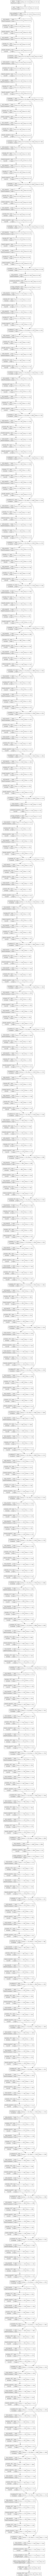

In [13]:
plot_model(densenet121,show_shapes=True)

In [14]:
densenet121.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_densenet121 = densenet121.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 95s 53ms/step - loss: 6.3742 - accuracy: 0.0553
Epoch 2/100
1563/1563 [==============================] - 79s 50ms/step - loss: 5.8993 - accuracy: 0.1062
Epoch 3/100
1563/1563 [==============================] - 72s 46ms/step - loss: 5.6071 - accuracy: 0.1397
Epoch 4/100
1563/1563 [==============================] - 85s 55ms/step - loss: 5.3934 - accuracy: 0.1704
Epoch 5/100
1563/1563 [==============================] - 84s 54ms/step - loss: 5.2048 - accuracy: 0.1993
Epoch 6/100
1563/1563 [==============================] - 83s 53ms/step - loss: 5.0389 - accuracy: 0.2217
Epoch 7/100
1563/1563 [==============================] - 84s 54ms/step - loss: 4.8984 - accuracy: 0.2475
Epoch 8/100
1563/1563 [==============================] - 85s 54ms/step - loss: 4.7559 - accuracy: 0.2714
Epoch 9/100
1563/1563 [==============================] - 82s 52ms/step - loss: 4.6281 - accuracy: 0.2939
Epoch 10/100
1563/1563 [==============================]

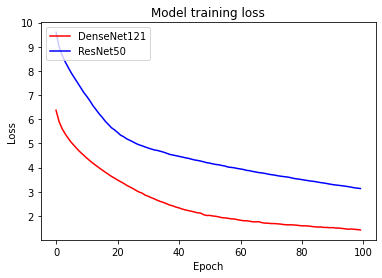

In [15]:
import matplotlib.pyplot as plt

plt.plot(history_densenet121.history['loss'],'r')
plt.plot(history_resnet50.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['DenseNet121','ResNet50'], loc='upper left')
plt.show()

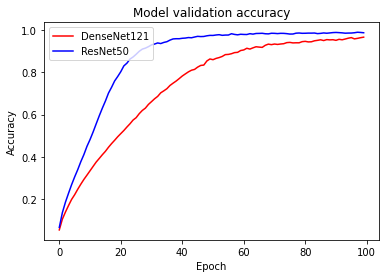

In [16]:
plt.plot(history_densenet121.history['accuracy'], 'r')
plt.plot(history_resnet50.history['accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DenseNet121', 'ResNet50'], loc='upper left')
plt.show()